# Carga de librarias

In [26]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px 

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix, accuracy_score

from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Bidirectional, Lambda
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [30]:
# Plot del training loss i l'accuracy
def plot_prediction(n_epochs, mfit):
    # TODO
    #Plots 
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

    # plot accuracy during training
    ax[0].set_title('Mse')
    ax[0].plot(mfit.history['mse'], label='train')
    ax[0].plot(mfit.history['val_mse'], label='test')
    ax[0].legend()
    # plot loss during training
    ax[1].set_title('Loss')
    ax[1].plot(mfit.history['loss'], label='train')
    ax[1].plot(mfit.history['val_loss'], label='test')
    ax[1].legend()

def cut_cycles(df, lookback, future, column_features, column_label):
    df_feature = df[column_features]
    df_rul = df[column_label][lookback-1:]

    # Convertimos el dataframe en un numpy array
    numpy_features = df_feature.to_numpy()
    labels = df_rul.to_numpy()
    
    # Creación de listas vacías auxiliares
    features_set = [] 
   
    for i in range(lookback, df.shape[0] - future + 1):
        features_set.append(numpy_features[i - lookback:i]) 

    # Redimensionamiento numpy arrays
    features = np.array(features_set)
    features = np.reshape(features, (features.shape[0], features.shape[1], len(column_features) ))

    return features, labels

def modelo_lstm(input_shape, optimizer):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=30, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    return model

---
# Carga de datos

In [31]:
DATA_DIR = "C:/Users/NetRunner/OneDrive/UOC/Semestre 6/TFM/MultipleDatasets"

train_data = pd.read_csv(f"{DATA_DIR}/train_data_uncut.csv")
test_data = pd.read_csv(f"{DATA_DIR}/test_data_uncut.csv")

# X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
# y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")
# X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
# y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

In [32]:
data = pd.concat([train_data, test_data])
features = ['volt','rotate','pressure','vibration','error1','error2','error3','error4','error5', 
            'volt_3h_mean', 'rotate_3h_mean', 'pressure_3h_mean', 'vibration_3h_mean', 'volt_24h_mean',
            'rotate_24h_mean', 'pressure_24h_mean', 'vibration_24h_mean', 'error1_count', 'error2_count', 
            'error3_count', 'error4_count', 'error5_count']
label = ['RUL']

print(len(train_data))
print(len(test_data))
print(len(data))

40397
8305
48702


In [33]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
label_scaler = MinMaxScaler(feature_range=(0,1))

feature_scaler.fit(data[features])
label_scaler.fit(data[label].values.reshape(-1,1))

MinMaxScaler()

In [34]:
data_norm = data[features+label].copy()
data_norm[features] = feature_scaler.transform(data[features])
data_norm[label] = label_scaler.transform(data[label].values.reshape(-1,1))
data_norm

,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,volt_3h_mean,...,volt_24h_mean,rotate_24h_mean,pressure_24h_mean,vibration_24h_mean,error1_count,error2_count,error3_count,error4_count,error5_count,RUL
0,0.376540,0.506008,0.329144,0.290724,0.0,0.0,0.0,0.0,0.0,0.258985,...,0.272094,0.372207,0.253195,0.069114,0.000000,0.000000,0.0,0.000000,0.000000,0.105580
1,0.346974,0.394241,0.377751,0.520788,0.0,0.0,0.0,0.0,0.0,0.238611,...,0.244295,0.270370,0.291375,0.278737,0.000000,0.000000,0.0,0.000000,0.000000,0.105348
2,0.414927,0.547666,0.485632,0.340661,0.0,0.0,0.0,0.0,0.0,0.263038,...,0.277623,0.329620,0.360593,0.239197,0.000000,0.000000,0.0,0.000000,0.000000,0.105117
3,0.414022,0.466269,0.203238,0.299181,0.0,0.0,0.0,0.0,0.0,0.280258,...,0.293861,0.322163,0.284295,0.200529,0.000000,0.000000,0.0,0.000000,0.000000,0.104885
4,0.370395,0.496337,0.399222,0.403736,0.0,0.0,0.0,0.0,0.0,0.291018,...,0.287197,0.328647,0.300093,0.215434,0.000000,0.000000,0.0,0.000000,0.000000,0.104654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8300,0.590798,0.475231,0.302635,0.713366,0.0,0.0,0.0,0.0,0.0,0.383354,...,0.450955,0.383491,0.228750,0.602701,0.285714,0.166667,1.0,0.333333,0.333333,0.000926
8301,0.455103,0.397862,0.347602,0.679191,0.0,0.0,0.0,0.0,0.0,0.414840,...,0.448400,0.371331,0.220916,0.617316,0.285714,0.166667,1.0,0.333333,0.333333,0.000695
8302,0.509347,0.509059,0.472205,0.454234,0.0,0.0,0.0,0.0,0.0,0.454524,...,0.442911,0.368975,0.230355,0.604771,0.285714,0.166667,1.0,0.333333,0.333333,0.000463
8303,0.638858,0.588679,0.231742,0.533214,0.0,0.0,0.0,0.0,0.0,0.476603,...,0.456270,0.371157,0.220723,0.602018,0.285714,0.166667,1.0,0.333333,0.333333,0.000232


In [35]:
train_norm = data_norm[:len(train_data)].sample(frac = 1)
test_norm = data_norm[len(train_data):(len(train_data)+len(test_data))].sample(frac = 1)

# train_norm = data_norm[:len(train_data)]
# test_norm = data_norm[len(train_data):(len(train_data)+len(test_data))]

X_train = train_norm.loc[:, train_norm.columns != 'RUL']
y_train = train_norm.loc[:, train_norm.columns == 'RUL']
X_test = test_norm.loc[:, test_norm.columns != 'RUL']
y_test = test_norm.loc[:, test_norm.columns == 'RUL']

---
# Modelo LSTM

In [36]:
rangos = 72

train_3d = cut_cycles(train_norm, rangos, 0, features, label)

X_train_3d = train_3d[0]
y_train_3d = train_3d[1]


test_3d = cut_cycles(test_norm, rangos, 0, features, label)

X_test_3d = test_3d[0]
y_test_3d = test_3d[1]

print('X_train_3d:\t', X_train_3d.shape)
print('y_train_3d:\t', y_train_3d.shape)
print('X_test_3d:\t', X_test_3d.shape)
print('y_test_3d:\t', y_test_3d.shape)

X_train_3d:	 (40326, 72, 22)
y_train_3d:	 (40326, 1)
X_test_3d:	 (8234, 72, 22)
y_test_3d:	 (8234, 1)


In [9]:
%%time
epochs = [100]
batches = [8, 16]
optimizers = ['adam', 'rmsprop']
lrs = [0.01, 0.001, 0.0001] 
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

for epoch in epochs:
    for batch in batches:
        for opt in optimizers:
            for lr in lrs:
                if opt == 'adam':
                    optimizer = Adam(learning_rate=lr)
                elif opt == 'rmsprop':
                    optimizer = RMSprop(learning_rate=lr)
                
                model = modelo_lstm(input_shape, optimizer)
                
                print('=========Training model==========')

                print('Hiperparámetros:')
                print('Optimizer:\t', opt)
                print('Learning Rate:\t', lr)
                print('Epochs:\t\t', epoch)
                print('Batch:\t\t', batch)
                
                res_m = model.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=epoch, batch_size=batch, verbose = 0, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)])
                
                pred = model.predict(X_test_3d)
                pred
                pred_list = [x[0] for x in pred]



                print('\nEvaluation:')
                print('R^2 score:\t\t', r2_score(y_test_3d, pred_list))
                print('MSE score:\t\t', mean_squared_error(y_test_3d, pred_list))
                print('MAE score:\t\t', mean_absolute_error(y_test_3d, pred_list))
                
                print('=================================\n')

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.01
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
258/258 [==============================] - 4s 13ms/step

Evaluation:
R^2 score:		 -0.018165368059613662
MSE score:		 0.013052174240349866
MAE score:		 0.09866697421510383

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping
258/258 [==============================] - 4s 14ms/step

Evaluation:
R^2 score:		 -0.049661912677579245
MSE score:		 0.013455938109382361
MAE score:		 0.0907398016624642

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.0001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
258/258 [==============================] - 5s 16ms/step

Eva

In [40]:
epochs = 1
optimizer = Adam(learning_rate=0.01)
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

model = modelo_lstm(input_shape, optimizer)

res_m = model.fit(X_train_3d, y_train_3d, validation_split=0.2, epochs=epochs, batch_size=16, verbose = 1, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)])


2017/2017 [==============================] - 203s 99ms/step - loss: 0.0859 - mse: 0.0859 - val_loss: 0.0812 - val_mse: 0.0812


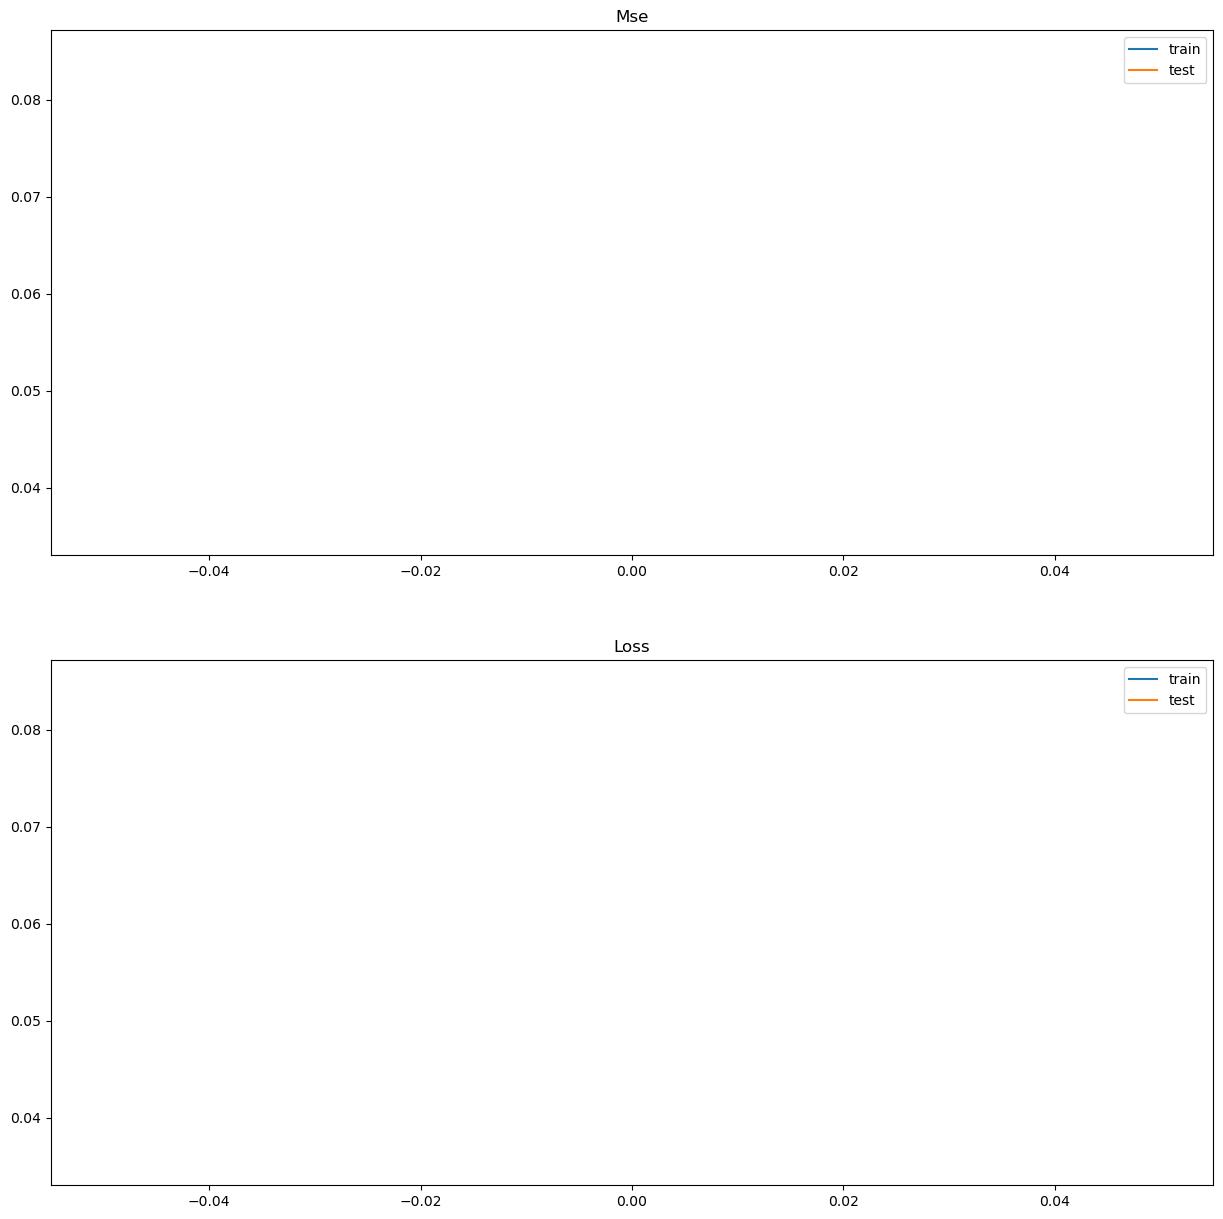

In [38]:
plot_prediction(epochs, res_m)

258/258 [==============================] - 14s 53ms/step


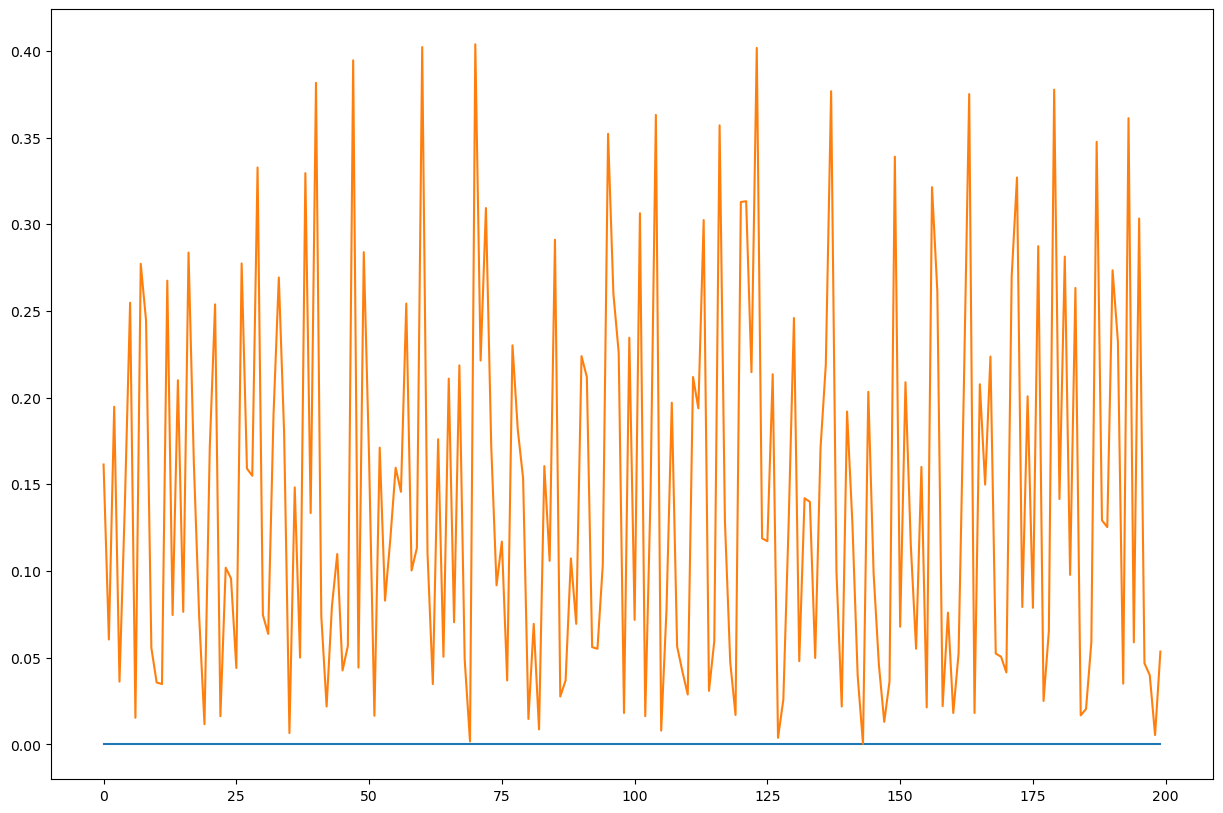

In [41]:
y_test_3d_5 = y_test_3d
pred = model.predict(X_test_3d)
temp_list = []
for i in range(pred.shape[0]):
    temp_list.append(pred[i])

    
plt.figure(figsize=(15, 10))
plt.plot(temp_list[:200])
plt.plot(y_test_3d_5[:200])
plt.show()